## Summary

<p>
The goal of this project is to optimize memory usage of large (or medium sized) data sets within Pandas. The data set used concerns the exhibitions of the <a href="https://www.moma.org/">Museum of modern art</a>. The data set is taken from <a href="https://data.world/moma/exhibitions">data world</a>. Thanks a lot for their good work!
</p> 

<p>
According to data world the exhibition index dataset was compiled by a project team from the MoMA Archives as part of their work to preserve, describe, and open to the public over 22,000 folders of exhibition records dating from 1929 to 1989 from its registrar and curatorial departments.            
<p>

<p>
Memory usage is a challenge when processing data for example with machine
learning algorithms. Memory usage can easily stress or override the 
memory capacity of a single machine, when working with medium size or large data sets. This can lead to hours of processing time. Of course it is possible to employ more machines with parallel computing and use tools like <a href="https://spark.apache.org/"> Spark</a> or others.</p>
    
<p>
There are of course repercussions. For example the
fine data analysis capabilities of Pandas are not matched every time 
with tools like <a href="https://dask.org/">Dask </a> for now. Also
as user friendly those tools often are those require set up time. Often you would like to do at least initial work on a single machine, before moving on or not. In this case determining the memory footprint and optimizing data processing comes in handy. 
Besides Pandas works easily with different SQL tools, which can
further reduce the memory footprint.
</p>

<p>
For optimizing data processing the following tasks are carried out here:
</p>

<ul>

<li>data import</li>
<li>data visualization</li>
<li>make use of arguments of read_csv</li>  
<li>understanding the memory footprint</li>
<li>calculating memory size on different levels</li>
<li>understanding the influence of data types on the the memory footprint</li>  
<li>finding the subdatatype, which stores a variablewith the lowest memory footprint</li>
<li>dealing with categorical variables</li>
<li>calculating memory savings</li>
<li>reading in data with chunks</li>
<li>combining values generated within each chunk into one total object as a pandas series and benchmark with timeit</li>

</ul>
    
<p>
Comments are and explanations are given within the coding.
A conclusion is made at the end.
</p> 


In [189]:
import os 
dirpath = os.getcwd()
foldername = os.path.basename(dirpath)
os.chdir("../mona")
dirpath = os.getcwd()

## Import packages

In [318]:
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import timeit

plt.rcParams['font.size'] = 11
plt.rcParams['font.style'] = 'italic'
plt.rcParams['font.family'] = 'monospace'

import numpy as np
print("numpy version: ", np.__version__)
import scipy.stats
import math
import os
import types
from random import sample
from random import choices
import random
import warnings

numpy version:  1.16.2


## Import data

In [191]:
modernart = \
pd.read_csv('moma_exhibitions/moma.csv', low_memory=True, header=0, sep=',')

In [192]:
modernart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34558 entries, 0 to 34557
Data columns (total 27 columns):
ExhibitionID              34129 non-null float64
ExhibitionNumber          34558 non-null object
ExhibitionTitle           34558 non-null object
ExhibitionCitationDate    34557 non-null object
ExhibitionBeginDate       34558 non-null object
ExhibitionEndDate         33354 non-null object
ExhibitionSortOrder       34558 non-null float64
ExhibitionURL             34125 non-null object
ExhibitionRole            34424 non-null object
ConstituentID             34044 non-null float64
ConstituentType           34424 non-null object
DisplayName               34424 non-null object
AlphaSort                 34424 non-null object
FirstName                 31499 non-null object
MiddleName                3804 non-null object
LastName                  31998 non-null object
Suffix                    157 non-null object
Institution               2458 non-null object
Nationality               26

The memory usage is substantial with memory usage: 7.1+ MB.

In [193]:
modernart.shape

(34558, 27)

34558 observations or records and 27 variables.

### What is the size of the memory footprint?
<p>
According to Wikipedia the memory footprint refers to the amount of 
main memory that a program uses or references while running.
</p>


In [194]:
moma_blockdata = modernart._data
print(type(moma_blockdata))
print(moma_blockdata)

<class 'pandas.core.internals.managers.BlockManager'>
BlockManager
Items: Index(['ExhibitionID', 'ExhibitionNumber', 'ExhibitionTitle',
       'ExhibitionCitationDate', 'ExhibitionBeginDate', 'ExhibitionEndDate',
       'ExhibitionSortOrder', 'ExhibitionURL', 'ExhibitionRole',
       'ConstituentID', 'ConstituentType', 'DisplayName', 'AlphaSort',
       'FirstName', 'MiddleName', 'LastName', 'Suffix', 'Institution',
       'Nationality', 'ConstituentBeginDate', 'ConstituentEndDate',
       'ArtistBio', 'Gender', 'VIAFID', 'WikidataID', 'ULANID',
       'ConstituentURL'],
      dtype='object')
Axis 1: RangeIndex(start=0, stop=34558, step=1)
FloatBlock: [0, 6, 9, 19, 20, 23, 25], 7 x 34558, dtype: float64
ObjectBlock: [1, 2, 3, 4, 5, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 21, 22, 24, 26], 20 x 34558, dtype: object


Numerics are stored as numpy arrays with 8 bytes for each
value. Storing values in numpy arrays is computational efficient.
Turning objects like strings into numerics will therefore
decrease the memory usage.

In [195]:
byte_size_float = 34558 * 8
print(byte_size_float)

276464


In [196]:
# the ConstituentBeginDate column consists of 276464 bytes
print(modernart.ConstituentBeginDate.nbytes)
# the ULANID column consists of 276464 bytes
print(modernart.ULANID.nbytes)

276464
276464



Object columns store values likewise with 8 bytes but for a 
different reason. 
Objects store a pointer of 8 bytes pointing to an adress in memory.
This gives a false impression of the actual memory needed to store
the object columns.

In [197]:

print(modernart.Gender.nbytes)
print(modernart.DisplayName.nbytes)

276464
276464


Calculating the exact memory size

In [198]:
# Return an int representing the number of elements in this object.
# Return the number of rows if Series. 
# Otherwise return the number of rows times number of columns if 
# DataFrame.
print(modernart.size)
print(modernart.shape[0]*modernart.shape[1])

933066
933066


In [199]:
full_bytesize = modernart.size * 8 
full_megabytes = full_bytesize / 1048576 
print(full_bytesize)
print(full_megabytes)
print(round(full_megabytes, 2))

7464528
7.1187286376953125
7.12


In [200]:
# Doc
# Specifies whether total memory usage of the 
# DataFrame elements (including the index) should be displayed. 
# Without deep introspection a memory estimation is
# made based in column dtype and number of rows assuming 
# values consume the same memory amount for corresponding dtypes. 
# With deep memory introspection, a real memory usage calculation 
# is performed at the cost of computational resources.

print(modernart.info(memory_usage='deep'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34558 entries, 0 to 34557
Data columns (total 27 columns):
ExhibitionID              34129 non-null float64
ExhibitionNumber          34558 non-null object
ExhibitionTitle           34558 non-null object
ExhibitionCitationDate    34557 non-null object
ExhibitionBeginDate       34558 non-null object
ExhibitionEndDate         33354 non-null object
ExhibitionSortOrder       34558 non-null float64
ExhibitionURL             34125 non-null object
ExhibitionRole            34424 non-null object
ConstituentID             34044 non-null float64
ConstituentType           34424 non-null object
DisplayName               34424 non-null object
AlphaSort                 34424 non-null object
FirstName                 31499 non-null object
MiddleName                3804 non-null object
LastName                  31998 non-null object
Suffix                    157 non-null object
Institution               2458 non-null object
Nationality               26

The full memory usage is 45.6 MB.

In [201]:
object_memory_size = 45.6 - 7.12
print(object_memory_size)

38.480000000000004


The object columns needs around 38.48 MB, but this is only
an rough assumption.

Determining the actual memory footprint

In [202]:
object_variables = modernart.select_dtypes(include=['object'])
print(object_variables.size)
print(object_variables.shape)

691160
(34558, 20)


Index                          80
ExhibitionNumber          2085250
ExhibitionTitle           3467207
ExhibitionCitationDate    3577728
ExhibitionBeginDate       2281851
ExhibitionEndDate         2234872
ExhibitionURL             3494606
ExhibitionRole            2179383
ConstituentType           2313112
DisplayName               2548428
AlphaSort                 2534329
FirstName                 2104909
MiddleName                1218917
LastName                  2162937
Suffix                    1110333
Institution               1221368
Nationality               1949664
ArtistBio                 3183300
Gender                    1858994
WikidataID                1821293
ConstituentURL            2677922
dtype: int64


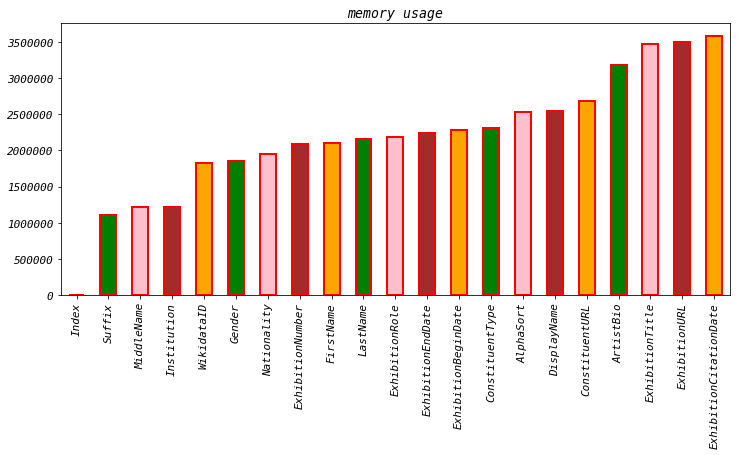

In [285]:
memory_used_object = object_variables.memory_usage(deep=True)
print(memory_used_object)

memory_used_object.sort_values().plot(kind='bar',color=['orange', 'g', 'pink', 'brown'],
                                      edgecolor='red', linewidth=2, figsize=(12,5),
                                      title="memory usage")

In [204]:
ob_mem_sum = memory_used_object.sum()
print(round(ob_mem_sum, 2))

ob_mem_sum_mb = ob_mem_sum.sum() /  1048576 
print(round(ob_mem_sum_mb, 2))


45892971
43.77


Of the total used memory of 45.6 MB 43.77 MB are used by the object
(string) columns. Converting string into numerics will drastically
decrease the memory usage.

#### Subtypes of data types

<p>
Subtypes are subset of base data types. Both make the data type familiy.
Subtypes are adapted to represent only a range of values of the parent 
data type. Using subtypes instead of the base data type reduces the memory
footprint.
</p> 

In [205]:
# int8 represent 8 bits or 1 byte and can represent 2^8 = 256 values 
# from -128 to 127
print(np.iinfo("int8"))

Machine parameters for int8
---------------------------------------------------------------
min = -128
max = 127
---------------------------------------------------------------



In [206]:
print(np.iinfo("int8").max)
print(np.iinfo("int8").min)

127
-128


In [207]:
int_types = ["int8", "int16", "int32", "int64"]
for it in int_types:
     print(np.iinfo(it))

Machine parameters for int8
---------------------------------------------------------------
min = -128
max = 127
---------------------------------------------------------------

Machine parameters for int16
---------------------------------------------------------------
min = -32768
max = 32767
---------------------------------------------------------------

Machine parameters for int32
---------------------------------------------------------------
min = -2147483648
max = 2147483647
---------------------------------------------------------------

Machine parameters for int64
---------------------------------------------------------------
min = -9223372036854775808
max = 9223372036854775807
---------------------------------------------------------------



In [208]:
modernart.select_dtypes(include="float").isnull().sum()

ExhibitionID              429
ExhibitionSortOrder         0
ConstituentID             514
ConstituentBeginDate     9268
ConstituentEndDate      14739
VIAFID                   7562
ULANID                  12870
dtype: int64

In [209]:
ex_max = modernart.ExhibitionSortOrder.max()
ex_min = modernart.ExhibitionSortOrder.min()

print(ex_max)
print(ex_min)

print(np.iinfo("int8").max)
print(np.iinfo("int8").min)

1768.0
1.0
127
-128


Finding the subdatatype, which stores a variable (ExhibitionSortOrder) 
with the lowest memory footprint.

In [210]:
if ex_max < np.iinfo("int8").max and ex_min > np.iinfo("int8").min:
    print("int8:", True)
    ex_8 = modernart.ExhibitionSortOrder.astype("int8")
    print("memory usage:",ex_8.memory_usage(deep=True), "bytes")
    print("data type:", ex_8.dtype)
else:
    print("int8:", False)
    
if ex_max < np.iinfo("int16").max and ex_min > np.iinfo("int16").min:
    print('int16:', True)
    ex_16 = modernart.ExhibitionSortOrder.astype("int16")
    print("memory usage:",ex_16.memory_usage(deep=True), "bytes")
    print("data type:", ex_16.dtype)
else:
    print('int16:', False)
    
if ex_max < np.iinfo("int32").max and ex_min > np.iinfo("int32").min:
    print('int32:', True)
    ex_32 = modernart.ExhibitionSortOrder.astype("int32")
    print("memory usage:", ex_32.memory_usage(deep=True), "bytes")
    print("data type:", ex_32.dtype)
else:
    print('int32:', False)
    
if ex_max < np.iinfo("int64").max and ex_min > np.iinfo("int64").min:
    print('int64:', True)
    ex_64 = modernart.ExhibitionSortOrder.astype("int64")
    print("memory usage:", ex_64.memory_usage(deep=True), "bytes")
    print("data type:", ex_64.dtype)
else:
    print('int64:', False)

int8: False
int16: True
memory usage: 69196 bytes
data type: int16
int32: True
memory usage: 138312 bytes
data type: int32
int64: True
memory usage: 276544 bytes
data type: int64


The values in column ExhibitionSortOrder are stored with the
smallest memory usage: 69196 as in16. All other subtypes increase the 
memory footprint.

In [211]:
total_bytes = len(modernart)*2 + 80 
# 80 bytes are needed for the index
# this makes then the total memory usage
print(total_bytes)

69196


In [212]:
# the downcast parameter determines the optimal subtype with the
# lowest memory footprint

modernart.ExhibitionSortOrder = modernart.ExhibitionSortOrder.astype('int')
before_1 = modernart.ExhibitionSortOrder.dtype
print(before_1)
modernart.ExhibitionSortOrder= \
pd.to_numeric(modernart.ExhibitionSortOrder, downcast='integer')
print(modernart.ExhibitionSortOrder.dtype)

int32
int16


In [213]:
float_cols = modernart.select_dtypes(include=['float'])

print(float_cols.dtypes)
print(type(float_cols))
print(float_cols.shape)


ExhibitionID            float64
ConstituentID           float64
ConstituentBeginDate    float64
ConstituentEndDate      float64
VIAFID                  float64
ULANID                  float64
dtype: object
<class 'pandas.core.frame.DataFrame'>
(34558, 6)


In [214]:
for col in float_cols.columns:
    print(col)

ExhibitionID
ConstituentID
ConstituentBeginDate
ConstituentEndDate
VIAFID
ULANID


In [215]:
for col in float_cols.columns:
    modernart[col] = pd.to_numeric(modernart[col], downcast='float')

# print(modernart.dtypes)   
    
float_cols_2 = modernart.select_dtypes(include=['float32']).dtypes

print(float_cols_2)
print(float_cols_2.memory_usage(deep=True))

ExhibitionID            float32
ConstituentID           float32
ConstituentBeginDate    float32
ConstituentEndDate      float32
VIAFID                  float32
ULANID                  float32
dtype: object
1041


The float data types are casted down to float 32, which lead less values 
than float 64.

#### Are there variables of type datetime?

In [216]:
modernart.select_dtypes(include=['object']).dtypes[:6]

ExhibitionNumber          object
ExhibitionTitle           object
ExhibitionCitationDate    object
ExhibitionBeginDate       object
ExhibitionEndDate         object
ExhibitionURL             object
dtype: object

There are some columns with dates.

In [217]:
dates = ['ExhibitionCitationDate' , 'ExhibitionBeginDate',
         'ExhibitionEndDate']
for i in dates:
    print(type(modernart.loc[3,i]))

<class 'str'>
<class 'str'>
<class 'str'>


In [218]:
for i in dates:
    print(modernart.loc[:3,i])

0    [MoMA Exh. #1, November 7-December 7, 1929]
1    [MoMA Exh. #1, November 7-December 7, 1929]
2    [MoMA Exh. #1, November 7-December 7, 1929]
3    [MoMA Exh. #1, November 7-December 7, 1929]
Name: ExhibitionCitationDate, dtype: object
0    11/7/1929
1    11/7/1929
2    11/7/1929
3    11/7/1929
Name: ExhibitionBeginDate, dtype: object
0    12/7/1929
1    12/7/1929
2    12/7/1929
3    12/7/1929
Name: ExhibitionEndDate, dtype: object


Relevant are ExhibitionBeginDate and ExhibitionEndDate.

In [219]:
for i in dates:
    print(modernart[i].isnull().sum())

1
0
1204


In [220]:
modernart['ExhibitionBeginDate']= \
pd.to_datetime(modernart['ExhibitionBeginDate'], format='%m/%d/%Y')

modernart['ExhibitionEndDate']= \
pd.to_datetime(modernart['ExhibitionEndDate'], format='%m/%d/%Y')

In [221]:
modernart.select_dtypes(include=['datetime']).dtypes

ExhibitionBeginDate    datetime64[ns]
ExhibitionEndDate      datetime64[ns]
dtype: object

In [222]:
print(modernart['ExhibitionBeginDate'].memory_usage(deep=True))
print(modernart['ExhibitionEndDate'].memory_usage(deep=True))

276544
276544


#### Categorical variables
<p>
are stored internally as integers
by mapping a dictionary onto the categorical variable. 
This is similar to encoding explicitly in scikit.
Converting from type object or string to a categorical
variable reduces the memory footprint.
</p> 

In [223]:
print(modernart.ConstituentType.value_counts())
print(modernart.ConstituentType.unique())
# the values are strings

Individual     32008
Institution     2416
Name: ConstituentType, dtype: int64
['Individual' nan 'Institution']


In [224]:
print(modernart.ConstituentType.memory_usage(deep=True))

2313192


In [225]:
modernart.ConstituentType = modernart.ConstituentType.astype('category')
print(modernart.ConstituentType.memory_usage(deep=True))

34853


In [226]:
2313192 - 34853

2278339

Storing as categorical variables resulted in the reduction of
2278339 bytes.
Unless you ask for the integers the categorical values are still displayed as strings.

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
dtype: int8
 0    32008
 1     2416
-1      134
dtype: int64


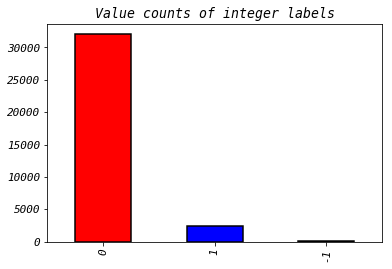

In [265]:
print(modernart.ConstituentType.cat.codes.head(10))
print(modernart.ConstituentType.cat.codes.value_counts())

# -1 are the null values, which type categorical can handle
# meaning cleaning is not needed beforehand

modernart.ConstituentType.cat.codes.value_counts().plot(kind='bar', color=['r','b','g'],
                                                        edgecolor="black", linewidth=1.5,
                                                        title="Value counts of integer labels")

Investigating the unique values of variables of type object.
Variables where unique values make less than 50 percent of
total count of values are transformed into categorical variables.
If every values is unique 

In [228]:
object_names = \
modernart.select_dtypes(include=['object']).dtypes.index.to_list()

In [229]:
ratio_unique_total = {}

for i in object_names:
    unique_len = len(modernart[i].unique())
    total_len = len(modernart[i])
    ratio = round(unique_len / total_len, 2)
    
    ratio_unique_total[i] = ratio
    

In [230]:
# investigating the resulting dictionary
print(len(ratio_unique_total))
print(ratio_unique_total)
print(ratio_unique_total.items())
print(ratio_unique_total.keys())
print(ratio_unique_total.values())

17
{'ExhibitionNumber': 0.05, 'ExhibitionTitle': 0.05, 'ExhibitionCitationDate': 0.05, 'ExhibitionURL': 0.05, 'ExhibitionRole': 0.0, 'DisplayName': 0.34, 'AlphaSort': 0.34, 'FirstName': 0.09, 'MiddleName': 0.02, 'LastName': 0.22, 'Suffix': 0.0, 'Institution': 0.05, 'Nationality': 0.0, 'ArtistBio': 0.1, 'Gender': 0.0, 'WikidataID': 0.1, 'ConstituentURL': 0.33}
dict_items([('ExhibitionNumber', 0.05), ('ExhibitionTitle', 0.05), ('ExhibitionCitationDate', 0.05), ('ExhibitionURL', 0.05), ('ExhibitionRole', 0.0), ('DisplayName', 0.34), ('AlphaSort', 0.34), ('FirstName', 0.09), ('MiddleName', 0.02), ('LastName', 0.22), ('Suffix', 0.0), ('Institution', 0.05), ('Nationality', 0.0), ('ArtistBio', 0.1), ('Gender', 0.0), ('WikidataID', 0.1), ('ConstituentURL', 0.33)])
dict_keys(['ExhibitionNumber', 'ExhibitionTitle', 'ExhibitionCitationDate', 'ExhibitionURL', 'ExhibitionRole', 'DisplayName', 'AlphaSort', 'FirstName', 'MiddleName', 'LastName', 'Suffix', 'Institution', 'Nationality', 'ArtistBio', 'G

In [231]:
# query key, value pairs with less than 50 percent unique values.

ratio_above_50 = \
{(k,v) for k,v in ratio_unique_total.items() if v < 0.5}
print(ratio_above_50 )
print(len(ratio_above_50))

# all key, value pairs have less than 50 percent unique values.

{('Suffix', 0.0), ('ExhibitionCitationDate', 0.05), ('Institution', 0.05), ('MiddleName', 0.02), ('ExhibitionTitle', 0.05), ('ConstituentURL', 0.33), ('Nationality', 0.0), ('ExhibitionNumber', 0.05), ('ExhibitionURL', 0.05), ('AlphaSort', 0.34), ('Gender', 0.0), ('ArtistBio', 0.1), ('DisplayName', 0.34), ('FirstName', 0.09), ('WikidataID', 0.1), ('LastName', 0.22), ('ExhibitionRole', 0.0)}
17


In [232]:
# showing newly created datatypes category
modernart_2 = modernart.copy()
object_22 = modernart_2.select_dtypes(include=['object'])
modernart_2[object_22.columns.to_list()] = object_22.astype('category')
print(modernart_2.select_dtypes(include=['category']).dtypes)

ExhibitionNumber          category
ExhibitionTitle           category
ExhibitionCitationDate    category
ExhibitionURL             category
ExhibitionRole            category
ConstituentType           category
DisplayName               category
AlphaSort                 category
FirstName                 category
MiddleName                category
LastName                  category
Suffix                    category
Institution               category
Nationality               category
ArtistBio                 category
Gender                    category
WikidataID                category
ConstituentURL            category
dtype: object


In [233]:
obj_mem_1 = \
modernart_2[object_22.columns.to_list()].memory_usage(deep=True)
obj_mem_2 = \
modernart[object_22.columns.to_list()].memory_usage(deep=True)

In [234]:
comp_mem = pd.concat([obj_mem_2, obj_mem_1], axis=1)
comp_mem.columns = ['obj', 'cat']
comp_mem['mem_saving'] = comp_mem.obj - comp_mem.cat
comp_mem

,obj,cat,mem_saving
Index,80,80,0
ExhibitionNumber,2085250,255893,1829357
ExhibitionTitle,3467207,313108,3154099
ExhibitionCitationDate,3577728,333456,3244272
ExhibitionURL,3494606,326782,3167824
ExhibitionRole,2179383,36263,2143120
DisplayName,2548428,1253535,1294893
AlphaSort,2534329,1246259,1288070
FirstName,2104909,341491,1763418
MiddleName,1218917,127542,1091375


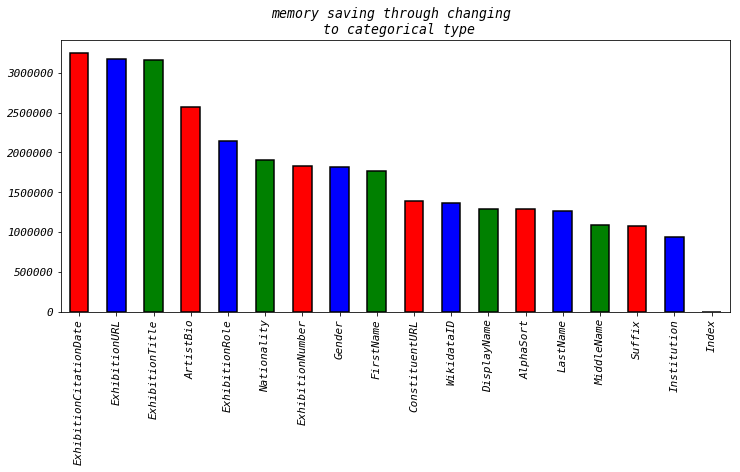

In [278]:
comp_mem['mem_saving'].sort_values(ascending=False).plot(kind='bar', color=['r','b','g'], 
                                                         edgecolor="black", linewidth=1.5,
                                                         title="memory saving through changing \n to categorical type",
                                                         figsize=(12,5))
plt.show()

#### Using read_csv arguments to change dtypes and reduce the memory footprint

In [235]:
date_vars = ['ExhibitionBeginDate', 'ExhibitionEndDate']

non_redundant_cols = \
['ExhibitionID', 'ExhibitionNumber', 'ExhibitionBeginDate', 
 'ExhibitionEndDate', 'ExhibitionSortOrder', 'ExhibitionRole', 
 'ConstituentType', 'DisplayName', 'Institution', 'Nationality', 
 'Gender']

col_types = {"id": np.int32}

In [236]:
modernart_3 = \
pd.read_csv('moma_exhibitions/moma.csv', low_memory=True, 
             header=0, sep=',' , parse_dates = date_vars,
             usecols=non_redundant_cols,
             dtype=col_types)

In [237]:
modernart_3.memory_usage(deep=True).sum()/(1024*1024)
# memory foot in megabytes

14.555106163024902

#### Chunks

<p>
Chunks are parts of a dataset. Reading in chunks reduces the memory size needed
at a time. This allows to process even large data sets.
However as every chunk is processed on it's own there are as many different
results of operations as there are chunks. The results must then be synthesized
with additional code.
</p> 

In [238]:
print(modernart.shape)

(34558, 27)


In [296]:
chunk_iter = pd.read_csv('moma_exhibitions/moma.csv', chunksize=1000)
print(type(chunk_iterations))
# chunksize returns an iteration object, which can then be iterated.

<class 'pandas.io.parsers.TextFileReader'>


In [240]:
len_chunks = []

for chunk in chunk_iter:
    len_chunks.append(len(chunk))
    
print(len_chunks)

[1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 558]


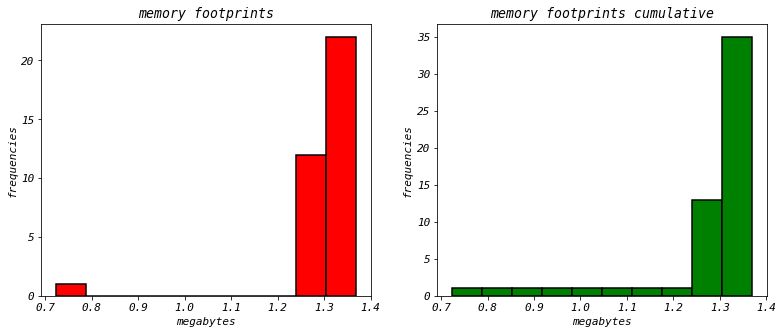

In [258]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,5))

ax1.hist(memory_footprints, color="red", edgecolor='black', linewidth=1.5)
ax1.set_xlabel('megabytes')
ax1.set_ylabel('frequencies')
ax1.set_title("memory footprints")

ax2.hist(memory_footprints, color="green", edgecolor='black', linewidth=1.5, cumulative = True)
ax2.set_xlabel('megabytes')
ax2.set_ylabel('frequencies')
ax2.set_title("memory footprints cumulative")

plt.show()

In [342]:
chunk_iter_2 = pd.read_csv('moma_exhibitions/moma.csv', chunksize=1000)

num_rows = 0

for chunk in chunk_iter_2:
    num_rows += len(chunk)

In [343]:
print(num_rows)
print(modernart.shape)

34558
(34558, 27)


#### Combining values generated within each chunk into one total object as a pandas series and benchmark with timeit.

#### Constituent

In [444]:
%%timeit
coltypes_2 = {'ConstituentBeginDate': float, 'ConstituentEndDate':float} 
chunk_iter_3 = pd.read_csv('moma_exhibitions/moma.csv', chunksize=1000, dtype=coltypes_2)
const_spreads = []
for chunk in chunk_iter_3:
        diff = chunk.ConstituentEndDate - chunk.ConstituentBeginDate
        const_spreads.append(diff)

1.07 s ± 62.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [445]:
combine_spreads = pd.concat(const_spreads)

print(type(combine_spreads))
print(combine_spreads.shape)
print(combine_spreads[:10])

<class 'pandas.core.series.Series'>
(34558,)
0    79.0
1    67.0
2    55.0
3    37.0
4    32.0
5    74.0
6    52.0
7    41.0
8    85.0
9    65.0
dtype: float64


In [446]:
%%timeit

coltypes_3 = {'ConstituentBeginDate': float, 'ConstituentEndDate':float} 
chunk_iter_3 = pd.read_csv('moma_exhibitions/moma.csv', chunksize=1000, dtype=coltypes_3,
                            usecols=['ConstituentBeginDate', 'ConstituentEndDate'])
const_spreads_2 = []
for chunk in chunk_iter_3:
        diff = chunk.ConstituentEndDate - chunk.ConstituentBeginDate
        const_spreads_2.append(diff)

781 ms ± 103 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Using only the columns necessary for the operation reduces the runtime significantly from 1.04 s
to 668 ms.

#### Gender

Male      23268
Female     2527
Name: Gender, dtype: int64


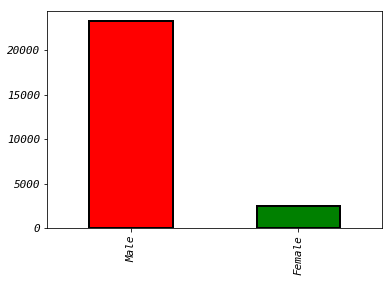

In [447]:
modernart_55 = modernart[modernart.Gender != 'male']
print(modernart_55.Gender.value_counts())
modernart_55.Gender.value_counts().plot(kind='bar', color= ['r' , 'g'], edgecolor="black", linewidth=2)

In [465]:
chunk_iter_4 = pd.read_csv('moma_exhibitions/moma.csv', chunksize=1000, 
                            usecols=['Gender'])
total_vc_gender = list()
for chunk in chunk_iter_4:
    vc = chunk['Gender'].value_counts()
    total_vc_gender.append(vc)

concat_vc_gender = pd.concat(total_vc_gender)

In [470]:
print(len(total_vc_gender))
print(type(concat_vc_gender))
print(concat_vc_gender.head())

35
<class 'pandas.core.series.Series'>
Male      700
Female     29
Male      633
Female     35
Male      578
Name: Gender, dtype: int64


In [473]:
gender_group = concat_vc_gender.groupby(concat_vc_gender.index).sum()
gender_group 

Female     2527
Male      23268
male          1
Name: Gender, dtype: int64

#### Gender groupby exhibition

In [483]:
chunk_iter_6 = pd.read_csv('moma_exhibitions/moma.csv', chunksize=1000, 
                            usecols=['Gender', 'ExhibitionID'])

In [484]:
gen_ex = list()

for chunk in chunk_iter_6:
    gr = chunk['Gender'].groupby(chunk['ExhibitionID']).value_counts()
    gen_ex.append(gr)
    
print(len(gen_ex))

35


In [488]:
conc_genex = pd.concat(gen_ex)

print(len(conc_genex))
print(type(conc_genex))
print(conc_genex[5:9])

2259
<class 'pandas.core.series.Series'>
ExhibitionID  Gender
2608.0        Male      47
              Female     1
2614.0        Male      53
              Female     1
Name: Gender, dtype: int64


In [493]:
conc_genex.groupby(by=['Gender']).sum()

Gender
Female     2482
Male      22940
male          1
Name: Gender, dtype: int64

## Conclusion

<p>
Pandas allows to reduce the memory footprint for example by determining 
the sub datatype with the lowest memory usage, turning strings into
numbers and read in data in chunks. Of course reading data into chunks
requires additional code to synthetize statistics from the number of chunks.
Overall Pandas offers a large range of methods for optimization of memory
usage. It also helps to think about the essentially needed data instead
of simply increasing power.
</p> 
